# NLP Project
### Goal: Create a model that best predicts programming languages of Github repositories 

### Plan 

Scrape Github repositories to exaluate the README sections and build a model that will predict which programming language is used. 
- 100 repositories used 
- 8 different models

### **Data Dictionary**

   - **Language:** Programming language used for repositort project

   - **README Content:** Description of each repository containing keywords used to make predictions

   - **Normalized:** README content normalized removing any uppercased characters, special characters, non-alpha characters, and alpha strings with 2 or less characters

   - **Stemmed:** README content reducing each word to its (psuedo)root 

   - **Lemmatized:** README content reducing each word to liguistically valid lemmas

   - **Cleaned:** README content that has been lemmatized and then removes any stopwords 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from requests import get
from bs4 import BeautifulSoup
import os
import json
import re
import unicodedata

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)
from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier


import acquire
import prepare
from env import github_token

### Acquire

In [2]:
# Using our acquire.py file, we scraped URL's from Github to create a Corpus of data
#acquire.scrape_github_data()

In [3]:
original_df = pd.read_json('data.json')

In [4]:
original_df.head()

,language,readme_contents,repo
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,AIDungeon/AIDungeon
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",rclone/rclone
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,marblexu/PythonPlantsVsZombies
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",redox-os/orbtk
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,sailay1996/UAC_Bypass_In_The_Wild


In [5]:
original_df.shape

(107, 3)

In [6]:
# We can see that there are 7 null values in the language column
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    107 non-null object
repo               107 non-null object
dtypes: object(3)
memory usage: 2.6+ KB


In [7]:
original_df.language.value_counts()

JavaScript          25
Python              20
Ruby                 9
CSS                  9
Go                   7
HTML                 5
Java                 5
C++                  4
TypeScript           4
C                    2
Jupyter Notebook     2
PHP                  2
Clojure              1
Kotlin               1
Rust                 1
Haskell              1
CoffeeScript         1
C#                   1
Name: language, dtype: int64

In [8]:
# Drop any columns that do not have a language
original_df = original_df.dropna()

In [9]:
original_df.shape

(100, 3)

In [10]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    100 non-null object
repo               100 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


### Prepare

In [11]:
# Make a copy of the original data frame we brought in dropping the repo column
df = original_df[['language', 'readme_contents']]

In [12]:
df.head()

,language,readme_contents
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh..."
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl..."
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...


In [13]:
df = prepare.prep_contents(df)

In [14]:
# Using a function from our prepare.py file, we created a new df displaying new columns using different methods to clean up the data
df.head()

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...","[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...","<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...


In [15]:
# Since we created a new column titled 'original', we will drop readme_contents column
df = df.drop(columns='readme_contents')

In [16]:
df.head(2)

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...


In [17]:
# Look at the contents using the cleaned column to assure it is cleaned up as we want it to be
df.cleaned[0]

'aidungeon model dungeon temporarily unavailable download due cost working solution read aidungeon wa built pcc byu edu dungeon creating infinitely generated text adventure deep learning language model play game colab aidungeon play game locally recommended nvidia gpu memory cuda installed gpu turn take couple minute game compose response install play locally git clone aidungeon aidungeon aidungeon install python play community aidungeon open source project question discussion contribution welcome contribution anything new package bugfixes documentation even new core feature resource website aidungeon aidungeon aidungeon twitter creator nickwalton twitter nickwalton dev benjbay twitter benjbay reddit aidungeon reddit aidungeon discord aidungeon discord discord vcz contributing contributing aidungeon relatively easy send pull request help article using pull request fork send request make develop destination branch aidungeon repository nickwalton aidungeon prefer pr pep python org dev pe

**Takeaway:** Moving forward, we will use the 'cleanded' column to explore and model. We chose to move forward with the lemmatized and removed stopwords column due to the fact that lemmatize is more accurate than stemming, working with a dictionary rather than guessing the word.


### Explore

In [19]:
df.language.value_counts()

JavaScript          25
Python              20
Ruby                 9
CSS                  9
Go                   7
HTML                 5
Java                 5
C++                  4
TypeScript           4
C                    2
Jupyter Notebook     2
PHP                  2
Clojure              1
Kotlin               1
Rust                 1
Haskell              1
CoffeeScript         1
C#                   1
Name: language, dtype: int64

In [125]:
df.language.count()

94

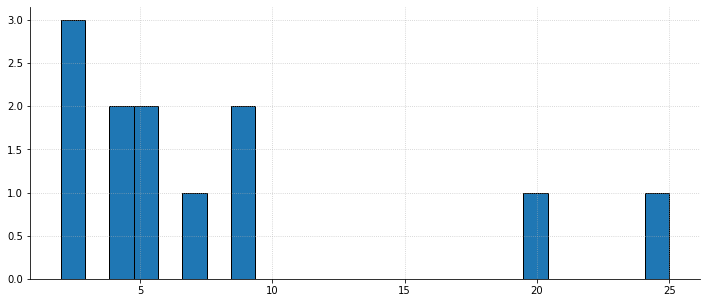

In [129]:
# plot distribution of languages

In [106]:
# We created a new df to display the number of times a language appears abd the percentages that each programming language is featured in our corpus
percents = pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)
percents

,n,percent
JavaScript,25,0.265957
Python,20,0.212766
Ruby,9,0.095745
CSS,9,0.095745
Go,7,0.074468
HTML,5,0.053191
Java,5,0.053191
TypeScript,4,0.042553
C++,4,0.042553
C,2,0.021277


In [107]:
# Moving forward with the cleaned column from out df, we will create a new series splitting the words
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()
raw_count

org                    593
img                    530
file                   466
svg                    455
src                    449
html                   380
doc                    341
code                   339
href                   324
use                    318
master                 292
cs                     289
project                280
license                279
plugin                 270
badge                  262
build                  242
install                219
line                   217
run                    213
image                  210
python                 208
png                    200
release                197
opencollective         197
using                  194
version                190
que                    189
target                 185
java                   185
                      ... 
patron                   1
clearly                  1
tweetstorms              1
upcoming                 1
nocion                   1
ethnicity                1
p

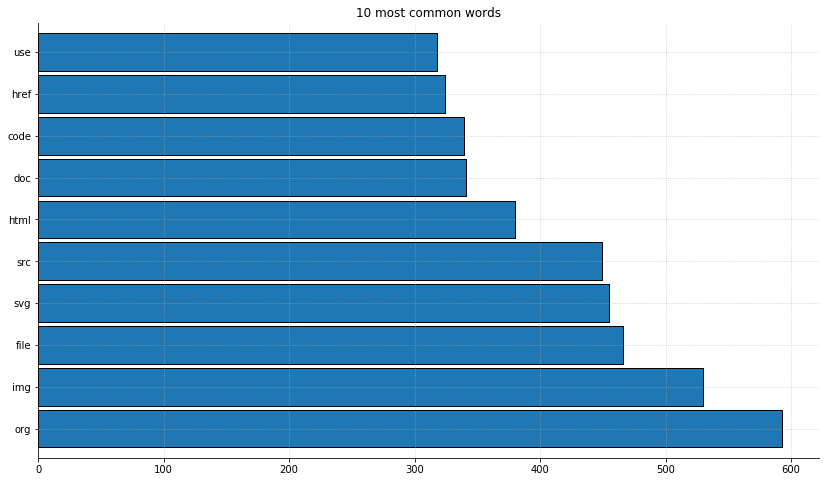

In [108]:
plt.figure(figsize=(14,8))
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')
plt.show()

In [130]:
tf_df = pd.DataFrame({'raw_count': raw_count})

tf_df = tf_df.assign(frequency = lambda df: df.raw_count / df.raw_count.sum())

tf_df = tf_df.assign(augmented_frequency = lambda df: df.frequency / df.frequency.max())

tf_df.frequency.max()

tf_df.head()

,raw_count,frequency,augmented_frequency
org,593,0.008830,1.000000
img,530,0.007892,0.893761
file,466,0.006939,0.785835
svg,455,0.006775,0.767285
src,449,0.006686,0.757167


In [131]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head()

,raw_count,frequency,augmented_frequency
org,593,0.008830,1.000000
img,530,0.007892,0.893761
file,466,0.006939,0.785835
svg,455,0.006775,0.767285
src,449,0.006686,0.757167


Text(0.5, 1.0, 'IDF for a given word')

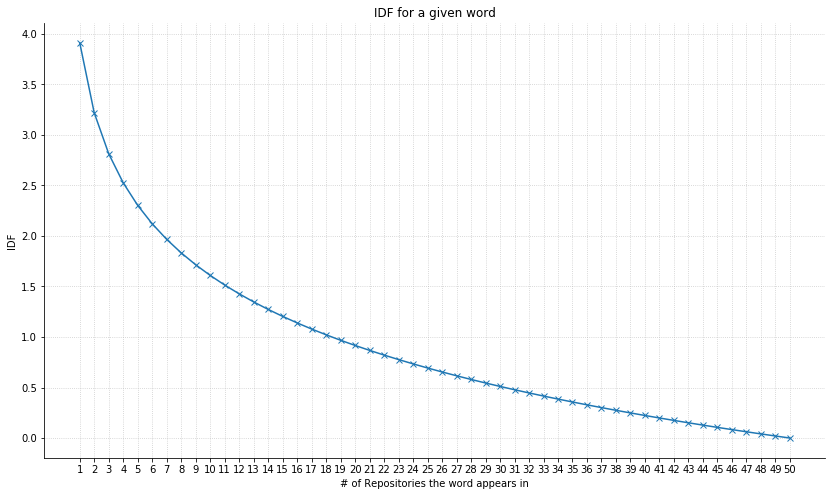

In [132]:
n_documents = 50

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(14, 8))
plt.plot(x_denominator, y_idf, marker='x')

plt.xticks(x_denominator)
plt.xlabel('# of Repositories the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

In [133]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [134]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

In [135]:
unique_words

array(['aidungeon', 'model', 'dungeon', ..., 'healthy', 'downstream',
       'schema'], dtype=object)

In [141]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(10)

,idf
word,
aidungeon,4.543295
dynamodb,4.543295
consequently,4.543295
simplehttpserver,4.543295
eahefnawy,4.543295
mailer,4.543295
laardee,4.543295
jetbridge,4.543295
tscanlin,4.543295


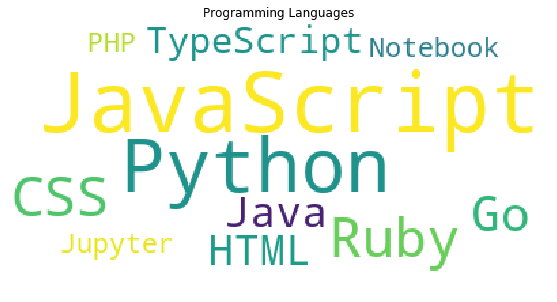

In [103]:
# Programming language value counts 
all_cloud = WordCloud(background_color='white').generate(' '.join(df.language))
plt.figure(figsize=(12, 5))
plt.imshow(all_cloud)
plt.title('Programming Languages')
plt.axis('off')
plt.show()

In [101]:
all_text = " ".join(df.cleaned)

In [32]:
all_words = prepare.clean(all_text)
all_words

['aidungeon',
 'model',
 'dungeon',
 'temporarily',
 'unavailable',
 'download',
 'due',
 'cost',
 'working',
 'solution',
 'read',
 'aidungeon',
 'wa',
 'built',
 'pcc',
 'byu',
 'edu',
 'dungeon',
 'creating',
 'infinitely',
 'generated',
 'text',
 'adventure',
 'deep',
 'learning',
 'language',
 'model',
 'play',
 'game',
 'colab',
 'aidungeon',
 'play',
 'game',
 'locally',
 'recommended',
 'nvidia',
 'gpu',
 'memory',
 'cuda',
 'installed',
 'gpu',
 'turn',
 'take',
 'couple',
 'minute',
 'game',
 'compose',
 'response',
 'install',
 'play',
 'locally',
 'git',
 'clone',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'install',
 'python',
 'play',
 'community',
 'aidungeon',
 'open',
 'source',
 'project',
 'question',
 'discussion',
 'contribution',
 'welcome',
 'contribution',
 'anything',
 'new',
 'package',
 'bugfixes',
 'documentation',
 'even',
 'new',
 'core',
 'feature',
 'resource',
 'website',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'twitter',
 'creator',
 'nickwalton',
 

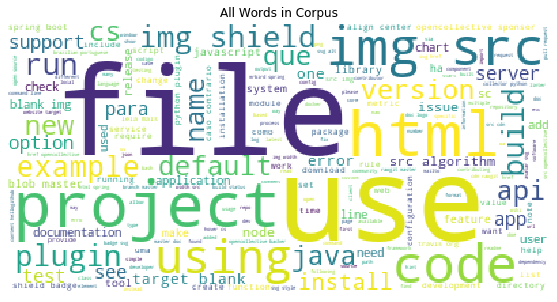

In [33]:
# Word cloud looking at all words in our corpus
img = WordCloud(background_color="white").generate(all_text)
plt.figure(figsize=(12, 5))
plt.imshow(img)
plt.axis("off")
plt.title('All Words in Corpus')
plt.show()

In [34]:
list(nltk.bigrams(all_text.split()))

[('aidungeon', 'model'),
 ('model', 'dungeon'),
 ('dungeon', 'temporarily'),
 ('temporarily', 'unavailable'),
 ('unavailable', 'download'),
 ('download', 'due'),
 ('due', 'cost'),
 ('cost', 'working'),
 ('working', 'solution'),
 ('solution', 'read'),
 ('read', 'aidungeon'),
 ('aidungeon', 'wa'),
 ('wa', 'built'),
 ('built', 'pcc'),
 ('pcc', 'byu'),
 ('byu', 'edu'),
 ('edu', 'dungeon'),
 ('dungeon', 'creating'),
 ('creating', 'infinitely'),
 ('infinitely', 'generated'),
 ('generated', 'text'),
 ('text', 'adventure'),
 ('adventure', 'deep'),
 ('deep', 'learning'),
 ('learning', 'language'),
 ('language', 'model'),
 ('model', 'play'),
 ('play', 'game'),
 ('game', 'colab'),
 ('colab', 'aidungeon'),
 ('aidungeon', 'play'),
 ('play', 'game'),
 ('game', 'locally'),
 ('locally', 'recommended'),
 ('recommended', 'nvidia'),
 ('nvidia', 'gpu'),
 ('gpu', 'memory'),
 ('memory', 'cuda'),
 ('cuda', 'installed'),
 ('installed', 'gpu'),
 ('gpu', 'turn'),
 ('turn', 'take'),
 ('take', 'couple'),
 ('coupl

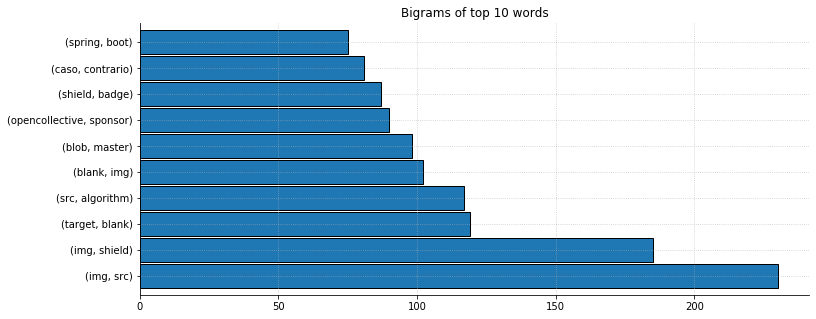

In [104]:
plt.figure(figsize=(12,5))
pd.Series(nltk.bigrams(all_words)).value_counts().head(10).plot.barh(width=.95)
plt.title('Bigrams of top 10 words')
plt.show()

In [35]:
list(nltk.ngrams(all_text.split(), 3))

[('aidungeon', 'model', 'dungeon'),
 ('model', 'dungeon', 'temporarily'),
 ('dungeon', 'temporarily', 'unavailable'),
 ('temporarily', 'unavailable', 'download'),
 ('unavailable', 'download', 'due'),
 ('download', 'due', 'cost'),
 ('due', 'cost', 'working'),
 ('cost', 'working', 'solution'),
 ('working', 'solution', 'read'),
 ('solution', 'read', 'aidungeon'),
 ('read', 'aidungeon', 'wa'),
 ('aidungeon', 'wa', 'built'),
 ('wa', 'built', 'pcc'),
 ('built', 'pcc', 'byu'),
 ('pcc', 'byu', 'edu'),
 ('byu', 'edu', 'dungeon'),
 ('edu', 'dungeon', 'creating'),
 ('dungeon', 'creating', 'infinitely'),
 ('creating', 'infinitely', 'generated'),
 ('infinitely', 'generated', 'text'),
 ('generated', 'text', 'adventure'),
 ('text', 'adventure', 'deep'),
 ('adventure', 'deep', 'learning'),
 ('deep', 'learning', 'language'),
 ('learning', 'language', 'model'),
 ('language', 'model', 'play'),
 ('model', 'play', 'game'),
 ('play', 'game', 'colab'),
 ('game', 'colab', 'aidungeon'),
 ('colab', 'aidungeon',

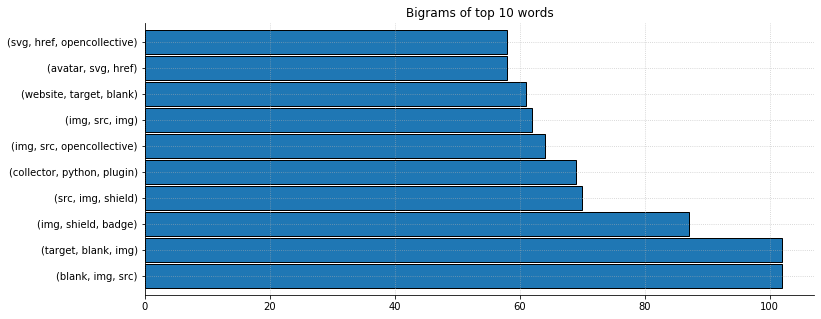

In [37]:
plt.figure(figsize=(12,5))
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(10).plot.barh(width=.95)
plt.title('Bigrams of top 10 words')
plt.show()

In [38]:
# plt.figure(figsize=(12,5))
# df.cleaned.plot.hist()
# plt.title('Frequency of Words')
# plt.show()

In [39]:
# A lot of bigrams are single letters or spaces
top_20_ham_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams

(img, src)                   230
(img, shield)                185
(target, blank)              119
(src, algorithm)             117
(blank, img)                 102
(blob, master)                98
(opencollective, sponsor)     90
(shield, badge)               87
(caso, contrario)             81
(spring, boot)                75
(align, center)               74
(leia, mais)                  72
(travis, org)                 72
(src, img)                    71
(opencollective, backer)      71
(avatar, svg)                 71
(python, plugin)              71
(collector, python)           69
(command, line)               67
(brazilian, portuguese)       66
dtype: int64

In [40]:
# write a function to iterate and count each word in each repo
# plot length of each readme
# distributions of idf
# Do different programming languages use a different number of unique words?

In [41]:
#df["readme_length"] = len(all_words)

In [42]:
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...


### Model

In [43]:
# We want to look into the languages with only one appearance and remove those in order to run our models
df.language.value_counts()[df.language.value_counts() == 1]

Clojure         1
Kotlin          1
Rust            1
Haskell         1
CoffeeScript    1
C#              1
Name: language, dtype: int64

In [44]:
list(df.language.value_counts()[df.language.value_counts() == 1].index)

['Clojure', 'Kotlin', 'Rust', 'Haskell', 'CoffeeScript', 'C#']

In [45]:
df[df.language == 'Kotlin']
df = df.drop(20)
df[df.language == 'C#']
df = df.drop(21)
df[df.language == 'CoffeeScript']
df = df.drop(28)
df[df.language == 'Clojure']
df = df.drop(85)
df[df.language == 'Haskell']
df = df.drop(41)
df[df.language == 'Rust']
df = df.drop(3)

In [46]:
df = df.reset_index()

In [47]:
df.language.value_counts()

JavaScript          25
Python              20
Ruby                 9
CSS                  9
Go                   7
HTML                 5
Java                 5
TypeScript           4
C++                  4
C                    2
PHP                  2
Jupyter Notebook     2
Name: language, dtype: int64

#### *Logistic Regression*

In [48]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [49]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [50]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')

Accuracy: 31.58%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Jupyter Notebook  PHP  \
predicted                                                                    
CSS         0    0    7   0     0     0           0                 0    0   
Go          0    0    0   1     0     0           0                 0    0   
JavaScript  2    2    0   4     4     4          20                 2    2   
Python      0    1    0   0     0     0           0                 0    0   
Ruby        0    0    0   0     0     0           0                 0    0   

actual      Python  Ruby  TypeScript  
predicted                             
CSS              0     0           0  
Go               0     0           0  
JavaScript       0     4           3  
Python          16     0           0  
Ruby             0     3           0  
---


In [51]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---') 
print(classification_report(test.actual, test.predicted))

Accuracy: 31.58%
---
Confusion Matrix
actual      C++  CSS  Go  HTML  Java  JavaScript  Python  Ruby  TypeScript
predicted                                                                 
JavaScript    1    2   2     1     1           5       3     2           1
Python        0    0   0     0     0           0       1     0           0
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         1
         CSS       0.00      0.00      0.00         2
          Go       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         1
        Java       0.00      0.00      0.00         1
  JavaScript       0.28      1.00      0.43         5
      Python       1.00      0.25      0.40         4
        Ruby       0.00      0.00      0.00         2
  TypeScript       0.00      0.00      0.00         1

    accuracy                           0.32        19
   macro avg       0.14      0.14      0.09        19
weighted

#### *Decision Tree*

In [52]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [53]:
print(clf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [54]:
y_pred = clf.predict(X_train)
y_pred

array(['Python', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'CSS',
       'Python', 'JavaScript', 'C', 'JavaScript', 'JavaScript', 'Ruby',
       'JavaScript', 'CSS', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'Ruby', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Ruby', 'Python', 'CSS', 'JavaScript',
       'Ruby', 'Ruby', 'JavaScript', 'Ruby', 'JavaScript', 'CSS', 'Ruby',
       'JavaScript', 'Ruby', 'JavaScript', 'Ruby', 'JavaScript', 'Ruby',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'Ruby',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'TypeScript', 'Python',
       'JavaScript', 'C', 'Python', 'JavaScript', 'JavaScript', 'Ruby',
       'TypeScript', 'Ruby', 'Ruby', 'CSS', 'Python', 'JavaScript',
       'Python', 'JavaScript', 'Python', 'JavaScript'], dtype=object)

In [55]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.04      , 0.12      , 0.08      , 0.08      , 0.08      ,
        0.08      , 0.24      , 0.08      , 0.08      , 0.12      ,
        0.        , 0.        ],
       [0.04      , 0.12      , 0.08      , 0.08      , 0.08      ,
        0.08      , 0.24      , 0.08      , 0.08      , 0.12      ,
        0.        , 0.        ],
       [0.04      , 0.12      , 0.08      , 0.08      , 0.08      ,
        0.08      , 0.24      , 0.08      , 0.08      , 0.12      ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.04      , 0.12      , 0.08      , 0.08      , 0.08      ,
        0.08      , 0.24      , 0.08      , 0.08      , 0.12      ,
        0.        ,

In [56]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.63


In [57]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.42


In [58]:
confusion_matrix(y_train, y_pred)

array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0, 12,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2]])

#### *Random Forest*

In [59]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)

In [60]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [61]:
print(rf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [62]:
y_pred = rf.predict(X_train)
y_pred

array(['Python', 'JavaScript', 'JavaScript', 'Python', 'Python', 'Python',
       'Python', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'Python', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'Python', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python',

In [63]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.02131018, 0.04254374, 0.08505201, 0.06865679, 0.05898062,
        0.05031167, 0.22904648, 0.02393292, 0.02822233, 0.268059  ,
        0.09178943, 0.03209484],
       [0.01785328, 0.03647549, 0.09215414, 0.0880496 , 0.0429299 ,
        0.04352118, 0.24854764, 0.02225381, 0.0412584 , 0.22181926,
        0.10849955, 0.03663775],
       [0.01808531, 0.03802353, 0.16210653, 0.06167575, 0.03448629,
        0.0430737 , 0.28081069, 0.01774092, 0.0275855 , 0.1625892 ,
        0.10506671, 0.04875588],
       [0.02756274, 0.05653938, 0.07257518, 0.07873404, 0.05745688,
        0.05772857, 0.23144499, 0.03445391, 0.0259823 , 0.24468429,
        0.08669198, 0.02614575],
       [0.02801232, 0.04538557, 0.0682989 , 0.07026683, 0.06163285,
        0.06109642, 0.22572055, 0.03664168, 0.02096388, 0.26864015,
        0.07975373, 0.03358713],
       [0.02758285, 0.04650751, 0.06080244, 0.087415  , 0.05423564,
        0.05180237, 0.24303113, 0.02843334, 0.02846866, 0.24566967,
        0.09413746,

In [64]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.45


In [65]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.32


In [66]:
print(confusion_matrix(y_train, y_pred))

[[ 0  0  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  1  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0  2  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0 14  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]]


In [67]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.38      1.00      0.55        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.64      0.88      0.74        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.45        75
       macro avg       0.08      0.16      0.11        75
    weighted avg       0.24      0.45      0.30        75



#### *K-Nearest Neighbors*

In [68]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [69]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [70]:
y_pred = knn.predict(X_train)
y_pred

array(['Python', 'JavaScript', 'CSS', 'Python', 'Python', 'Go',
       'JavaScript', 'C', 'JavaScript', 'CSS', 'Python', 'JavaScript',
       'Go', 'C++', 'JavaScript', 'Go', 'C++', 'CSS', 'JavaScript',
       'Python', 'C++', 'JavaScript', 'Ruby', 'JavaScript', 'JavaScript',
       'JavaScript', 'Go', 'Python', 'JavaScript', 'Python', 'CSS',
       'JavaScript', 'JavaScript', 'Ruby', 'JavaScript', 'C', 'HTML',
       'CSS', 'JavaScript', 'JavaScript', 'Go', 'JavaScript', 'Python',
       'JavaScript', 'Go', 'JavaScript', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'C++',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'CSS', 'C', 'Python', 'Java', 'JavaScript', 'Go', 'JavaScript',
       'Ruby', 'Go', 'CSS', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript'], dtype=object)

In [71]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba

array([[0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0.8, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0.6, 0. , 0.2, 0. , 0. , 0. ],
       [0. , 0. , 0.8, 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0.2, 0. , 0.2, 0.4, 0. , 0. ],
       [0. , 0.2, 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0.4, 0.2, 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0.2, 0.2, 0. , 0. , 0. , 0.2, 0.2],
       [0. , 0. , 0.2, 0. , 0.2, 0. , 0.4, 0.2, 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0. , 0.4, 0. , 0. , 0.2, 0.2, 0. ],
       [0. , 0. , 0.6, 0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. ],
       [0. , 0. , 0.2, 0. , 0.2, 0. , 0.4, 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0. , 0.4, 0. , 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0

In [72]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.67


In [73]:
print(confusion_matrix(y_train, y_pred))

[[ 2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  1  0  1  2  0  0  0  0  0]
 [ 0  1  0  1  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0 14  0  0]
 [ 0  0  0  2  0  0  2  0  0  0  3  0]
 [ 1  0  0  0  0  0  2  0  0  0  0  0]]


In [74]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       0.67      1.00      0.80         2
             C++       0.25      0.33      0.29         3
             CSS       1.00      1.00      1.00         7
              Go       0.50      0.80      0.62         5
            HTML       0.00      0.00      0.00         4
            Java       1.00      0.25      0.40         4
      JavaScript       0.55      0.90      0.68        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.93      0.88      0.90        16
            Ruby       1.00      0.43      0.60         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.67        75
       macro avg       0.49      0.47      0.44        75
    weighted avg       0.65      0.67      0.62        75



In [75]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.58


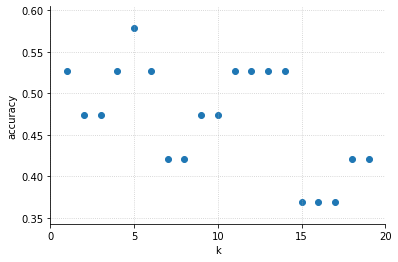

In [76]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [77]:
rng = np.random.RandomState(1)
X = X_train
y = y_train

clf = BernoulliNB()
clf.fit(X, y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [78]:
print(clf.predict(X))

['JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'Python'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'Python'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'C' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'Python' 'JavaScript' 'Python' 'JavaScript' 'Python'
 'JavaScript']


In [79]:
y_pred = clf.predict(X)
y_pred

array(['JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'C', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScri

In [80]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.00000000e+000, 0.00000000e+000, 2.60588352e-268,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        4.59448163e-016, 8.48838092e-283, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.28809930e-263,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        3.18828057e-041, 1.63319722e-278, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 8.43271273e-163,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        3.45809405e-069, 6.09451080e-262, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 3.20948602e-276,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        8.78864509e-038, 2.21761839e-296, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 2.50813162

In [81]:
print('Accuracy of Naive Bayes classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Naive Bayes classifier on training set: 0.35


In [82]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       1.00      0.50      0.67         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.29      1.00      0.45        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       1.00      0.31      0.48        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.35        75
       macro avg       0.19      0.15      0.13        75
    weighted avg       0.32      0.35      0.24        75



#### *Support Vector Machine (SVM)

In [83]:
X = X_train
y = y_train

clf = SVC(gamma='auto', kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [84]:
clf.predict(X)

array(['Python', 'JavaScript', 'CSS', 'C++', 'Python', 'Go', 'HTML', 'C',
       'JavaScript', 'CSS', 'Python', 'JavaScript', 'Java', 'C++',
       'JavaScript', 'Go', 'PHP', 'CSS', 'JavaScript', 'Python', 'Go',
       'JavaScript', 'Ruby', 'JavaScript', 'Jupyter Notebook',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'Python',
       'CSS', 'JavaScript', 'HTML', 'Ruby', 'JavaScript', 'TypeScript',
       'Jupyter Notebook', 'CSS', 'Ruby', 'JavaScript', 'Go',
       'JavaScript', 'Python', 'JavaScript', 'Ruby', 'JavaScript',
       'Python', 'JavaScript', 'Python', 'JavaScript', 'C++',
       'JavaScript', 'JavaScript', 'JavaScript', 'HTML', 'Python',
       'Python', 'TypeScript', 'Python', 'CSS', 'C', 'Python', 'Java',
       'JavaScript', 'Go', 'TypeScript', 'Ruby', 'Ruby', 'CSS', 'Python',
       'HTML', 'Python', 'JavaScript', 'Python', 'Java'], dtype=object)

In [85]:
print('Accuracy of Stochastic SVM on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Stochastic SVM on training set: 0.96


In [86]:
print('Accuracy of Stochastic SVM on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Stochastic SVM on training set: 0.37


#### *Stochastic Gradient Descent* 

In [87]:
X = X_train
y = y_train
# clf = linear_model.SGDClassifier(max_iter=, tol=1e-3)
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [88]:
clf.predict(X)

array(['Python', 'PHP', 'CSS', 'C++', 'Python', 'Go', 'HTML', 'C',
       'JavaScript', 'CSS', 'Python', 'JavaScript', 'Java', 'C++',
       'JavaScript', 'Go', 'PHP', 'CSS', 'JavaScript', 'Python', 'Go',
       'JavaScript', 'Ruby', 'JavaScript', 'Jupyter Notebook',
       'JavaScript', 'JavaScript', 'Python', 'Ruby', 'Python', 'CSS',
       'JavaScript', 'HTML', 'Ruby', 'JavaScript', 'TypeScript',
       'Jupyter Notebook', 'CSS', 'Ruby', 'JavaScript', 'Go',
       'JavaScript', 'Python', 'JavaScript', 'Ruby', 'JavaScript',
       'Python', 'JavaScript', 'Python', 'Java', 'C++', 'JavaScript',
       'JavaScript', 'JavaScript', 'HTML', 'Python', 'Python',
       'TypeScript', 'Python', 'CSS', 'C', 'Python', 'Java', 'JavaScript',
       'Go', 'TypeScript', 'Ruby', 'Ruby', 'CSS', 'Python', 'HTML',
       'Python', 'JavaScript', 'Python', 'Java'], dtype='<U16')

In [89]:
print('Accuracy of Stochastic Gradient Decent Classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Stochastic Gradient Decent Classifier on training set: 1.00


In [90]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       1.00      0.50      0.67         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.29      1.00      0.45        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       1.00      0.31      0.48        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.35        75
       macro avg       0.19      0.15      0.13        75
    weighted avg       0.32      0.35      0.24        75



In [91]:
print('Accuracy of Stochastic Gradient Decent classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Stochastic Gradient Decent classifier on test set: 0.42


#### *AdaBoost*

In [92]:
X = X_train
y = y_train
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [93]:
print(clf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [94]:
clf.predict(X)

array(['Python', 'PHP', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'C', 'JavaScript', 'JavaScript',
       'Python', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'PHP', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'TypeScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'TypeScript', 'Python',
       'JavaScript', 'C', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'TypeScript', 'JavaScript', 'JavaScript',
       'JavaScript'

In [95]:
clf.score(X, y)

0.5066666666666667

#### *Bagging*

In [96]:
X = X_train
y = y_train

clf = BaggingClassifier(n_estimators=3, random_state=0)
clf.fit(X, y)
clf.predict(X)

array(['Python', 'PHP', 'CSS', 'C++', 'Python', 'Go', 'HTML', 'C',
       'JavaScript', 'CSS', 'Python', 'JavaScript', 'Java', 'C++',
       'JavaScript', 'Go', 'PHP', 'CSS', 'JavaScript', 'Python', 'Go',
       'JavaScript', 'Ruby', 'JavaScript', 'C++', 'JavaScript',
       'JavaScript', 'Python', 'Ruby', 'Python', 'CSS', 'JavaScript',
       'HTML', 'Ruby', 'JavaScript', 'Jupyter Notebook',
       'Jupyter Notebook', 'CSS', 'Ruby', 'JavaScript', 'Ruby',
       'JavaScript', 'Ruby', 'JavaScript', 'Ruby', 'JavaScript', 'Python',
       'JavaScript', 'Python', 'Java', 'C++', 'JavaScript', 'Ruby',
       'JavaScript', 'HTML', 'Python', 'Python', 'JavaScript', 'Python',
       'CSS', 'C', 'Python', 'Java', 'JavaScript', 'JavaScript',
       'TypeScript', 'Ruby', 'Ruby', 'CSS', 'Python', 'HTML', 'Python',
       'JavaScript', 'Python', 'Java'], dtype=object)

In [97]:
print('Accuracy of Bagging classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Bagging classifier on training set: 0.91


In [98]:
clf.score(X_test, y_test)

0.47368421052631576

### Analysis

We scraped a random collection of Github repository README's in order to gather a diverse selection of programming languages. We found from this process that the most prominent language from our scraping was JavaScrit, followed by Python and then Ruby. 

In [ ]:
# to do:
# finish writing up analysis
# finish slides - well-rounded viz
# finish exploration
# presentation
# readme